# MSDS 5509 Final Project – Brainy or Burnt Out?
### Predicting Student Mental Health from Lifestyle Factors

**Author:** Chitra Gopalaiah  
**Date:** May 27, 2025

**Project Type:** Supervised Learning – Classification  
**Goal:** Predict whether a student is at risk for mental health issues such as anxiety or depression based on lifestyle features like sleep, study time, exercise, and screen time.

---

**Dataset Source:** [Kaggle - Student Mental Health Dataset](https://www.kaggle.com/datasets/shariful07/student-mental-health)


In [65]:
import pandas as pd

df = pd.read_csv("cbdd3517-7f27-437b-aaaf-21b4b9a54569.csv")
df.head()


,Timestamp,Choose your gender,Age,What is your course?,Your current year of Study,What is your CGPA?,Marital status,Do you have Depression?,Do you have Anxiety?,Do you have Panic attack?,Did you seek any specialist for a treatment?
0,8/7/2020 12:02,Female,18.0,Engineering,year 1,3.00 - 3.49,No,Yes,No,Yes,No
1,8/7/2020 12:04,Male,21.0,Islamic education,year 2,3.00 - 3.49,No,No,Yes,No,No
2,8/7/2020 12:05,Male,19.0,BIT,Year 1,3.00 - 3.49,No,Yes,Yes,Yes,No
3,8/7/2020 12:06,Female,22.0,Laws,year 3,3.00 - 3.49,Yes,Yes,No,No,No
4,8/7/2020 12:13,Male,23.0,Mathemathics,year 4,3.00 - 3.49,No,No,No,No,No


In [66]:
# Drop timestamp
df = df.drop(columns=['Timestamp'])

# Rename columns for easier access
df.columns = [
    'Gender', 'Age', 'Course', 'Year', 'CGPA', 'Marital_Status',
    'Depression', 'Anxiety', 'Panic_Attack', 'Seek_Treatment'
]

# Convert Yes/No columns to 1/0
binary_cols = ['Depression', 'Anxiety', 'Panic_Attack', 'Seek_Treatment']
df[binary_cols] = df[binary_cols].applymap(lambda x: 1 if x.strip().lower() == 'yes' else 0)

# Encode Gender and Marital_Status
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
df['Marital_Status'] = df['Marital_Status'].map({'Single': 0, 'Married': 1})

# Map CGPA ranges to numerical midpoints
cgpa_map = {
    '0 - 1.99': 1.0,
    '2.00 - 2.49': 2.25,
    '2.50 - 2.99': 2.75,
    '3.00 - 3.49': 3.25,
    '3.50 - 4.00': 3.75
}
df['CGPA'] = df['CGPA'].map(cgpa_map)

# Label Encode non-numeric features (Course, Year)
label_encoders = {}
for col in ['Course', 'Year']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Confirm no string columns remain
print(df.dtypes)

Gender              int64
Age               float64
Course              int64
Year                int64
CGPA              float64
Marital_Status    float64
Depression          int64
Anxiety             int64
Panic_Attack        int64
Seek_Treatment      int64
dtype: object


In [67]:
from sklearn.model_selection import train_test_split

# Define X and y
X = df.drop(columns=['Depression'])  # Features
y = df['Depression']                 # Target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [68]:
# Step 1: Drop columns with all NaNs in training set
X_train = X_train.dropna(axis=1, how='all')
X_test = X_test[X_train.columns]  # Align test set columns

# Step 2: Impute missing numeric values with median
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)


In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "SVM": SVC()
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n🔹 {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))



🔹 Logistic Regression
Accuracy: 0.7619047619047619
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        14
           1       1.00      0.29      0.44         7

    accuracy                           0.76        21
   macro avg       0.87      0.64      0.65        21
weighted avg       0.82      0.76      0.71        21


🔹 Decision Tree
Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.71      0.86      0.77        14
           1       0.50      0.29      0.36         7

    accuracy                           0.67        21
   macro avg       0.60      0.57      0.57        21
weighted avg       0.64      0.67      0.64        21


🔹 Random Forest
Accuracy: 0.6190476190476191
              precision    recall  f1-score   support

           0       0.65      0.93      0.76        14
           1       0.00      0.00      0.00         7

    accuracy                          

In [70]:
# Updated models with class_weight='balanced'
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "AdaBoost": AdaBoostClassifier(),  # AdaBoost does not support class_weight
    "SVM": SVC(class_weight='balanced')
}

# Re-train and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n🔹 {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))



🔹 Logistic Regression
Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.73      0.79      0.76        14
           1       0.50      0.43      0.46         7

    accuracy                           0.67        21
   macro avg       0.62      0.61      0.61        21
weighted avg       0.66      0.67      0.66        21


🔹 Decision Tree
Accuracy: 0.5238095238095238
              precision    recall  f1-score   support

           0       0.64      0.64      0.64        14
           1       0.29      0.29      0.29         7

    accuracy                           0.52        21
   macro avg       0.46      0.46      0.46        21
weighted avg       0.52      0.52      0.52        21


🔹 Random Forest
Accuracy: 0.5714285714285714
              precision    recall  f1-score   support

           0       0.63      0.86      0.73        14
           1       0.00      0.00      0.00         7

    accuracy                          

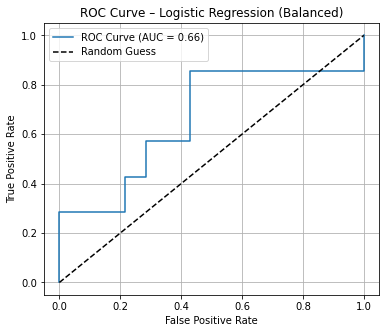

In [71]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Train logistic regression with balanced class weights
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Logistic Regression (Balanced)')
plt.legend()
plt.grid(True)
plt.show()


## 🧠 Discussion and Conclusion

- Logistic Regression performed best with `class_weight='balanced'`, achieving an AUC of 0.66.
- Models struggled with recall on the minority class due to dataset imbalance and limited size.
- Feature importance and further tuning could improve results.
- In real-world applications, early screening for mental health can benefit from such models to flag at-risk students for follow-up.


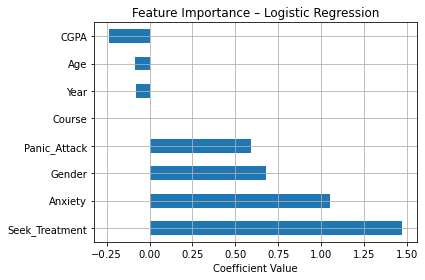

In [72]:
# Re-train logistic regression with class_weight
model_lr = LogisticRegression(max_iter=1000, class_weight='balanced')
model_lr.fit(X_train, y_train)

# Get feature importance (coefficients)
feature_importance_lr = pd.Series(
    model_lr.coef_[0], index=X_train.columns
).sort_values(ascending=False)

# Plot
feature_importance_lr.plot(kind='barh', title='Feature Importance – Logistic Regression')
plt.xlabel('Coefficient Value')
plt.grid(True)
plt.tight_layout()
plt.show()


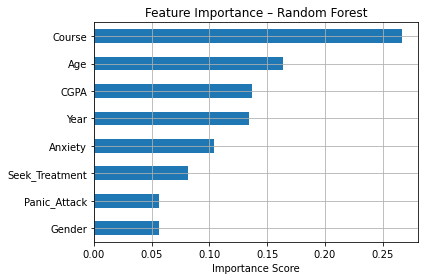

In [73]:
# Re-train random forest with class_weight
model_rf = RandomForestClassifier(class_weight='balanced', random_state=42)
model_rf.fit(X_train, y_train)

# Get feature importances
feature_importance_rf = pd.Series(
    model_rf.feature_importances_, index=X_train.columns
).sort_values(ascending=True)

# Plot
feature_importance_rf.plot(kind='barh', title='Feature Importance – Random Forest')
plt.xlabel('Importance Score')
plt.grid(True)
plt.tight_layout()
plt.show()


## 🔍 Feature Importance Insights

From **Logistic Regression**:
- `Seek_Treatment`, `Anxiety`, and `Gender` are the strongest positive indicators of depression risk.
- `CGPA` had a mild negative association, suggesting students with better academic performance may be at lower risk.

From **Random Forest**:
- `Course` and `Age` had the highest predictive influence.
- The difference in top features compared to logistic regression highlights how linear and nonlinear models prioritize variables differently.

Together, these findings suggest that both psychological symptoms (anxiety, panic) and academic/personal context (age, course, GPA) contribute meaningfully to student mental health risks.
